In [1]:
!unzip /kaggle/input/harshdata/dataset

unzip:  cannot find or open /kaggle/input/harshdata/dataset, /kaggle/input/harshdata/dataset.zip or /kaggle/input/harshdata/dataset.ZIP.


In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-70x1kpz3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-70x1kpz3
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.9 MB/s eta 0:00:0000:01
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6355133 sha256=03c28e31fc3e5df9f9471c1182c682d3079f6671b689c1319cf0802505c878ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-_vi2ffda/wheels/47/e5/15/94c80df2ba85

In [11]:
# detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode

# other libs (other necessary imports in Colab file to make the list shorter here)

import torch, torchvision
import torchvision.transforms as transforms

In [7]:
from pathlib import Path
def create_data_pairs(input_path, detectron_img_path, detectron_annot_path, dir_type):

    img_paths = Path(input_path + dir_type + '/images/').glob('*.png')

    pairs = []
    for img_path in img_paths:

        file_name_tmp = str(img_path).split('/')[-1].split('.')
        file_name_tmp.pop(-1)
        file_name = '.'.join((file_name_tmp))

        label_path = Path(input_path + dir_type + '/labels/' + file_name + '.txt')

        if label_path.is_file():

            line_img = detectron_img_path + dir_type+'/images/'+ file_name + '.png'
            line_annot = detectron_annot_path+dir_type+'/labels/' + file_name + '.txt'
            pairs.append([line_img, line_annot])

    return pairs

input_path = '/kaggle/input/harshdata/dataset/'

detectron_img_path = '/kaggle/input/harshdata/dataset/'
detectron_annot_path = '/kaggle/input/harshdata/dataset/'

train = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'train')
val = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'val')

In [8]:
import cv2
def create_coco_format(data_pairs):

    data_list = []

    for i, path in enumerate(data_pairs):

        filename = path[0]

        img_h, img_w = cv2.imread(filename).shape[:2]

        img_item = {}
        img_item['file_name'] = filename
        img_item['image_id'] = i
        img_item['height']= img_h
        img_item['width']= img_w

        print(str(i), filename)


        annotations = []
        with open(path[1]) as annot_file:
            lines = annot_file.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')

                class_id = box[0]
                x_c = float(box[1])
                y_c = float(box[2])
                width = float(box[3])
                height = float(box[4])

                x1 = (x_c - (width/2)) * img_w
                y1 = (y_c - (height/2)) * img_h
                x2 = (x_c + (width/2)) * img_w
                y2 = (y_c + (height/2)) * img_h

                annotation = {
                    "bbox": list(map(float,[x1, y1, x2, y2])),
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": int(class_id),
                    "iscrowd": 0
                }
                annotations.append(annotation)
            img_item["annotations"] = annotations
        data_list.append(img_item)
    return data_list

train_list = create_coco_format(train)
val_list = create_coco_format(val)
print(train_list)

0 /kaggle/input/harshdata/dataset/train/images/train_park_6_img_39.png
1 /kaggle/input/harshdata/dataset/train/images/train_park_5_img_35.png
2 /kaggle/input/harshdata/dataset/train/images/train_neighbourhood_2_img_29.png
3 /kaggle/input/harshdata/dataset/train/images/train_park_3_img_35.png
4 /kaggle/input/harshdata/dataset/train/images/train_park_5_img_97.png
5 /kaggle/input/harshdata/dataset/train/images/train_neighbourhood_7_img_50.png
6 /kaggle/input/harshdata/dataset/train/images/train_neighbourhood_2_img_39.png
7 /kaggle/input/harshdata/dataset/train/images/train_park_5_img_99.png
8 /kaggle/input/harshdata/dataset/train/images/train_neighbourhood_1_img_91.png
9 /kaggle/input/harshdata/dataset/train/images/train_neighbourhood_0_img_93.png
10 /kaggle/input/harshdata/dataset/train/images/train_neighbourhood_3_img_30.png
11 /kaggle/input/harshdata/dataset/train/images/train_park_7_img_98.png
12 /kaggle/input/harshdata/dataset/train/images/train_neighbourhood_7_img_77.png
13 /kaggle/

In [23]:
for catalog_name, file_annots in [("train2", train_list), ("val2", val_list)]:
    DatasetCatalog.register(catalog_name, lambda file_annots = file_annots: file_annots)
    MetadataCatalog.get(catalog_name).set(thing_classes=['ultra-thin', 'thin', 'poles', 'fence', 'wires', 'mesh', 'trees','forest','bungalow','car','miscellaneous'])

metadata = MetadataCatalog.get("train2")

metadata = MetadataCatalog.get("val2")

In [24]:
print(MetadataCatalog.get("train2").thing_classes)

['ultra-thin', 'thin', 'poles', 'fence', 'wires', 'mesh', 'trees', 'forest', 'bungalow', 'car', 'miscellaneous']


In [25]:
import os
import time as t
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


# Function to evaluate the model on the validation dataset
def evaluate_model(cfg, model, dataset_name):
    # Create the evaluator
    evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir="/kaggle/working/output")

    # Create the data loader for validation
    val_loader = build_detection_test_loader(cfg, dataset_name)

    # Perform inference on the validation dataset
    return inference_on_dataset(model, val_loader, evaluator)

cfg = get_cfg()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11 
# Setup configuration
train_size = len(train)
batch_size = cfg.SOLVER.IMS_PER_BATCH
max_iter = (train_size // batch_size) * 100
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train2",)  # Replace with your actual training dataset
cfg.DATASETS.TEST = ("val2",)  # Replace with your actual validation dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = 'cuda'  # 'cuda' or 'cpu'
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 5000
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = max_iter
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # 512
cfg.SOLVER.STEPS = (20500,)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Initialize the trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Train the model and evaluate periodically
s1 = t.time()

try:
    trainer.train()

    # Evaluate the model after training
    print("Evaluating the model on the validation dataset...")
    evaluate_model(cfg, trainer.model, cfg.DATASETS.TEST[0])

except Exception as e:
    print(f"Error during training: {e}")

s2 = t.time()

print(f"Training time: {s2 - s1} seconds")


[04/06 06:06:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 258MB/s]                             


[04/06 06:06:47 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/06 06:07:01 d2.utils.events]:  eta: 1:15:31  iter: 19  total_loss: 4.223  loss_cls: 2.476  loss_box_reg: 0.6617  loss_rpn_cls: 0.9212  loss_rpn_loc: 0.2087    time: 0.4473  last_time: 0.4779  data_time: 0.0264  last_data_time: 0.0055   lr: 1.9981e-05  max_mem: 3200M
[04/06 06:07:28 d2.utils.events]:  eta: 1:17:22  iter: 39  total_loss: 3.343  loss_cls: 2.045  loss_box_reg: 0.7474  loss_rpn_cls: 0.255  loss_rpn_loc: 0.2853    time: 0.4588  last_time: 0.4706  data_time: 0.0063  last_data_time: 0.0064   lr: 3.9961e-05  max_mem: 3200M
[04/06 06:07:37 d2.utils.events]:  eta: 1:18:08  iter: 59  total_loss: 2.534  loss_cls: 1.4  loss_box_reg: 0.8222  loss_rpn_cls: 0.129  loss_rpn_loc: 0.2415    time: 0.4603  last_time: 0.4657  data_time: 0.0057  last_data_time: 0.0057   lr: 5.9941e-05  max_mem: 3200M
[04/06 06:07:47 d2.utils.events]:  eta: 1:18:35  iter: 79  total_loss: 2.189  loss_cls: 1.031  loss_box_reg: 0.8222  loss_rpn_cls: 0.08355  loss_rpn_loc: 0.2329    time: 0.4629  last_time: 0.

[04/05 19:17:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


backbone.res2.0.conv1.norm.{bias, weight}
backbone.res2.0.conv1.weight
backbone.res2.0.conv2.norm.{bias, weight}
backbone.res2.0.conv2.weight
backbone.res2.0.conv3.norm.{bias, weight}
backbone.res2.0.conv3.weight
backbone.res2.0.shortcut.norm.{bias, weight}
backbone.res2.0.shortcut.weight
backbone.res2.1.conv1.norm.{bias, weight}
backbone.res2.1.conv1.weight
backbone.res2.1.conv2.norm.{bias, weight}
backbone.res2.1.conv2.weight
backbone.res2.1.conv3.norm.{bias, weight}
backbone.res2.1.conv3.weight
backbone.res2.2.conv1.norm.{bias, weight}
backbone.res2.2.conv1.weight
backbone.res2.2.conv2.norm.{bias, weight}
backbone.res2.2.conv2.weight
backbone.res2.2.conv3.norm.{bias, weight}
backbone.res2.2.conv3.weight
backbone.res3.0.conv1.norm.{bias, weight}
backbone.res3.0.conv1.weight
backbone.res3.0.conv2.norm.{bias, weight}
backbone.res3.0.conv2.weight
backbone.res3.0.conv3.norm.{bias, weight}
backbone.res3.0.conv3.weight
backbone.res3.0.shortcut.norm.{bias, weight}
backbone.res3.0.shortcut.w

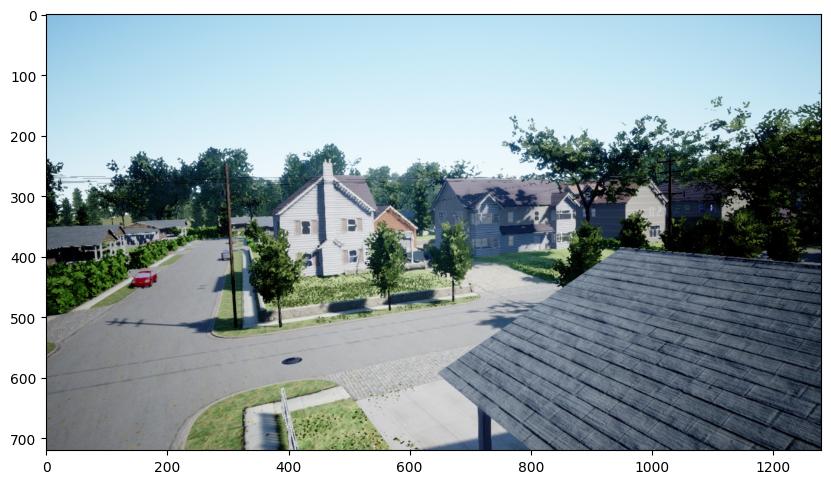

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
cfg = get_cfg()
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
predictor = DefaultPredictor(cfg)

im = cv2.imread("/content/train_neighbourhood_0_img_19.png")
outputs = predictor(im)
v = Visualizer(im, metadata=metadata, scale=1., instance_mode =  ColorMode.IMAGE    )

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:,:,[2,1,0]]
img = Image.fromarray(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)